Shared document to build and understand the suicide rate knowledge graph.

CS 575
Winter 2023

Brigham Young University

***
It helps to start with an overview of the data

In [1]:
from DatabaseManager import DatabaseManager # I don't know if it's good form to do this or not
database = DatabaseManager('datasets/suicide_rates_by_category.csv')
database.showHead()


   country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
4  Albania  1987    male  25-34 years            9      274300   
6  Albania  1987  female  35-54 years            6      278800   

   suicides_per_100k country-year  HDI_for_year  gdp_for_year  gdp_per_capita  \
0               6.71  Albania1987           NaN    2156624900             796   
1               5.19  Albania1987           NaN    2156624900             796   
2               4.83  Albania1987           NaN    2156624900             796   
4               3.28  Albania1987           NaN    2156624900             796   
6               2.15  Albania1987           NaN    2156624900             796   

     generation suicides_per_100k_bins  
0  Generation X                   0-25  
1        Silent                   

In [2]:
database.showInfo()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25076 entries, 0 to 27819
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 25076 non-null  object  
 1   year                    25076 non-null  int64   
 2   sex                     25076 non-null  object  
 3   age                     25076 non-null  object  
 4   suicides_no             25076 non-null  int64   
 5   population              25076 non-null  int64   
 6   suicides_per_100k       25076 non-null  float64 
 7   country-year            25076 non-null  object  
 8   HDI_for_year            7738 non-null   float64 
 9   gdp_for_year            25076 non-null  int64   
 10  gdp_per_capita          25076 non-null  int64   
 11  generation              25076 non-null  object  
 12  suicides_per_100k_bins  25076 non-null  category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 2.5+ MB
None


In [3]:
# The G.I. Generation doesn't have age categories for all groups
# I don't know why but it feels like we should drop that so that
# all generations have all age groups
database.showUniqueNodesOfType('generation')
database.cleanDatabase()
database.showUniqueNodesOfType('generation')

generation
Generation X    6408
Silent          6364
Millenials      5844
Boomers         4990
Generation Z    1470
dtype: int64
generation
Generation X    6408
Silent          6364
Millenials      5844
Boomers         4990
Generation Z    1470
dtype: int64


In [4]:

del database 
# I don't want to get confused later on in the notebook. 
# Deleting the database object will help keep small notebook blocks self contained.


***
We now need to decide on the graph schema. The DatabaseManager and GraphDatabaseManager classes depend on the graph schema we choose. The following schema just groups creates a node for each relevant row-column entry. We'd have to figure out how to merge things we care about later. Ignoring a lot of the columns for now.

![Graph schema version 0 of suicide database](GraphSchema_version0.svg)

A challenge with this kind of graph schema is merging nodes into meta categories. A second challenge is that suicide rate is a number which means that we could end up with one suicide rate number for every entry in the table. Let's address the second challenge by finding natural bins into which we can group suicide rates.

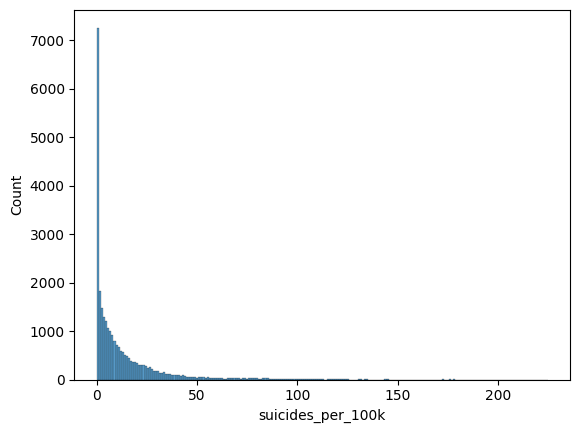

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

# Code patterned after https://www.kaggle.com/code/chingchunyeh/suicide-rates-overview-1985-to-2016
df = pd.read_csv('datasets/suicide_rates_by_category.csv')
df.rename(columns={"suicides/100k pop":"suicides_per_100k","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($) ":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)
#df.head()
sns.histplot(data=df,x="suicides_per_100k")
plt.show()



It looks to me like bins of around 25 will work well. This gives
 - 0-24
 - 25-49
 - 50-74
 - 75-99
 - 100-124
 - 125-149
 - 150-300 

In [6]:
# Update the database and show the bins
from DatabaseManager import DatabaseManager # I don't know if it's good form to do this or not
database = DatabaseManager('datasets/suicide_rates_by_category.csv')
database.binCategory('suicides_per_100k',binlist = [0,25,75,100,125,150,300])
database.showUniqueNodesOfType('suicides_per_100k_bins')

suicides_per_100k_bins
0-25       21712
25-75       2959
75-100       317
100-125       60
125-150       14
150-300       14
dtype: int64


***
I implemented the extraction of the database into a knowledge graph in GraphDatabaseManager.py. Here's a color coded graph, where the color indicates the type of node (see the graph schema above).

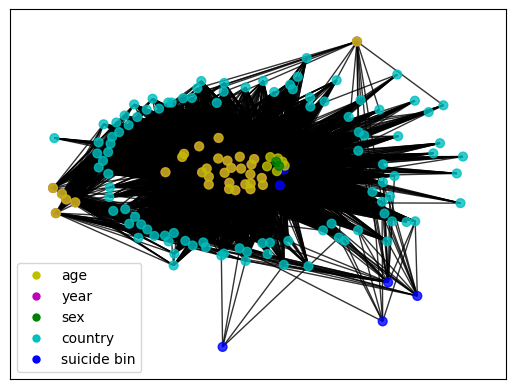

In [7]:
# Extract a knowledge graph
from GraphDatabaseManager import GraphManager
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

graph_database = GraphManager('datasets/suicide_rates_by_category.csv')
G = graph_database.getGraph_of_Database()
pos = nx.nx_agraph.graphviz_layout(G,prog='neato')
color_map = graph_database.getColormap_by_Nodetype()
plt.figure(1)
nx.draw_networkx(G,pos,node_color = color_map, alpha = 0.8, node_size = 40, with_labels = False)
ax = plt.gca()
age_line, = ax.plot(-np.inf,-np.inf,'y.',markersize = 10)
age_line.set_label('age')
year_line, = ax.plot(-np.inf,-np.inf,'m.',markersize = 10)
year_line.set_label('year')
sex_line, = ax.plot(-np.inf,-np.inf,'g.',markersize = 10)
sex_line.set_label('sex')
country_line, = ax.plot(-np.inf,-np.inf,'c.',markersize = 10)
country_line.set_label('country')
rate_line, = ax.plot(-np.inf,-np.inf,'b.',markersize = 10)
rate_line.set_label('suicide bin')
ax.legend()
plt.show()    